# 过拟合和欠拟合

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

## 生成数据集

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 1.0950],
         [-0.1402]]),
 tensor([[ 1.0000e+00,  1.0950e+00,  5.9946e-01,  2.1879e-01,  5.9893e-02,
           1.3116e-02,  2.3936e-03,  3.7441e-04,  5.1245e-05,  6.2345e-06,
           6.8265e-07,  6.7952e-08,  6.2004e-09,  5.2224e-10,  4.0845e-11,
           2.9816e-12,  2.0404e-13,  1.3142e-14,  7.9945e-16,  4.6072e-17],
         [ 1.0000e+00, -1.4018e-01,  9.8248e-03, -4.5907e-04,  1.6088e-05,
          -4.5102e-07,  1.0537e-08, -2.1101e-10,  3.6973e-12, -5.7586e-14,
           8.0723e-16, -1.0287e-17,  1.2016e-19, -1.2957e-21,  1.2973e-23,
          -1.2124e-25,  1.0622e-27, -8.7583e-30,  6.8206e-32, -5.0321e-34]]),
 tensor([5.4175, 4.7727]))

## 模型训练和测试

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

## 三阶多项式函数拟合(正常)

weight: [[ 5.0025916  1.2309251 -3.3900933  5.506214 ]]


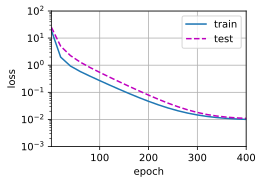

In [6]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

## 欠拟合

weight: [[3.8180556 2.9572258]]


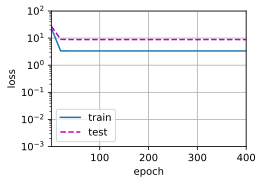

In [7]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

## 过拟合

weight: [[ 5.008667    1.2267859  -3.3753905   5.3138814  -0.25824842  1.2035159
   0.32658008 -0.04564949  0.10627735 -0.13043506  0.22021568  0.10208789
  -0.0735604   0.08921368  0.0762455   0.21919073  0.09401149  0.09881014
  -0.19582276  0.07663754]]


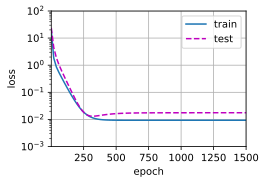

In [8]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)